In [1]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 33.4 MB/s 
     |████████████████████████████████| 5.5 MB 55.2 MB/s 
     |████████████████████████████████| 212 kB 74.5 MB/s 
     |████████████████████████████████| 163 kB 72.6 MB/s 
     |████████████████████████████████| 95 kB 5.1 MB/s 
     |████████████████████████████████| 115 kB 63.7 MB/s 
     |████████████████████████████████| 127 kB 69.0 MB/s 
     |████████████████████████████████| 7.6 MB 65.4 MB/s 
     |████████████████████████████████| 115 kB 75.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [3]:
!mkdir /root/.kaggle
!mv /content/kaggle.json  /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 2.29G/2.29G [01:46<00:00, 22.7MB/s]
100% 2.29G/2.29G [01:46<00:00, 23.0MB/s]


In [4]:
!unzip /content/chest-xray-pneumonia.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-04

In [5]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random
import numpy as np
import random
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [17]:
train_data_path = "/content/chest_xray/train"

train_data = []
val_data = []


tmp_data = {}
labels = []
# training data
for i, dir in enumerate(Path(train_data_path).iterdir()):
  label_id = i
  labels.append({
      'id': label_id,
      'label': dir.name
  })
  tmp_data[str(label_id)] = []
    
  for image in Path(dir).glob("*.jpeg"):
    image = Image.open(image)
    tmp_data[str(label_id)].append({
        'image': image,
        'labels': label_id
    })

# val data
for i, dir in enumerate(Path("/content/chest_xray/val").iterdir()):
  label_id = i
  for image in Path(dir).glob("*.jpeg"):
    image = Image.open(image)
    tmp_data[str(label_id)].append({
        'image': image,
        'labels': label_id
    })

for d in tmp_data:
    print('class label:', d, 'Length:', len(tmp_data[d]))
    val_data += tmp_data[d][-int(len(tmp_data[d])*0.1):]
    train_data += tmp_data[d][:-int(len(tmp_data[d])*0.1)]
    
print('labels', labels)

class label: 0 Length: 1349
class label: 1 Length: 3883
labels [{'id': 0, 'label': 'NORMAL'}, {'id': 1, 'label': 'PNEUMONIA'}]


In [9]:
test_data = []
test_data_path = "/content/chest_xray/test/"

for i, dir in enumerate(Path(test_data_path).iterdir()):
  label_id = i
  for image in Path(dir).glob("*.jpeg"):
    image = Image.open(image)
    test_data.append({
        'image': image,
        'labels': label_id
    })

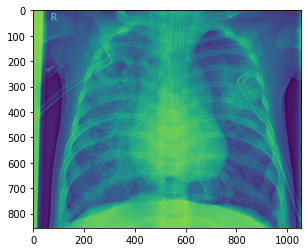

In [10]:
sample_image = train_data[random.randint(0, len(train_data))]
plt.imshow(sample_image['image'])
plt.show()

In [11]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments

# ViT Feature Extractor
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [40]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize,
                                    Grayscale,
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

_train_transforms = Compose(
        [
            # Grayscale(num_output_channels=1),
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            # Grayscale(num_output_channels=1),
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transform(batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([_train_transforms(x.convert("RGB")) for x in batch['image']], return_tensors='pt')

    inputs['labels'] = batch['labels']
    return inputs

def val_transform(batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([_val_transforms(x.convert("RGB")) for x in batch['image']], return_tensors='pt')

    inputs['labels'] = batch['labels']
    return inputs

In [41]:
from torch.utils import data
from datasets import Dataset, load_metric

train_dataset = Dataset.from_list(train_data) 
valid_dataset = Dataset.from_list(val_data) 
test_dataset = Dataset.from_list(test_data) 
print(train_dataset)
print(valid_dataset)
print(test_dataset)

prepared_train_ds = train_dataset.with_transform(train_transform)
prepared_val_ds = valid_dataset.with_transform(val_transform)
prepared_test_ds = test_dataset.with_transform(val_transform)


Dataset({
    features: ['image', 'labels'],
    num_rows: 4710
})
Dataset({
    features: ['image', 'labels'],
    num_rows: 522
})
Dataset({
    features: ['image', 'labels'],
    num_rows: 624
})


In [42]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }
    
metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [49]:
# Create the Vision Transformer Model
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    # num_channels=1,
    # patch_size=16
    # image_size=16*4,
    ignore_mismatched_sizes=True
)

# Training Args
training_args = TrainingArguments(
  output_dir="./vit-v1",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=10,
  fp16=True, # if no CURD -> False
  logging_steps=100,
  learning_rate=2e-5,
  save_total_limit=2,
  weight_decay=0.01,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.24.0"
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/pytorch_model.bin
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k

In [50]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train_ds,
    eval_dataset=prepared_val_ds,
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [51]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4710
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1480
  Number of trainable parameters = 85800194


Step,Training Loss,Validation Loss,Accuracy
100,0.348300,0.266993,0.879310
200,0.216600,0.187150,0.944444
300,0.214600,0.192119,0.929119
400,0.183900,0.170449,0.938697
500,0.176900,0.206917,0.921456
600,0.160500,0.151055,0.944444
700,0.149200,0.127686,0.955939
800,0.138000,0.129857,0.961686
900,0.139800,0.125937,0.955939
1000,0.146900,0.107951,0.963602


***** Running Evaluation *****
  Num examples = 522
  Batch size = 8
***** Running Evaluation *****
  Num examples = 522
  Batch size = 8
***** Running Evaluation *****
  Num examples = 522
  Batch size = 8
***** Running Evaluation *****
  Num examples = 522
  Batch size = 8
***** Running Evaluation *****
  Num examples = 522
  Batch size = 8
Saving model checkpoint to ./vit-v1/checkpoint-500
Configuration saved in ./vit-v1/checkpoint-500/config.json
Model weights saved in ./vit-v1/checkpoint-500/pytorch_model.bin
Feature extractor saved in ./vit-v1/checkpoint-500/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 522
  Batch size = 8
***** Running Evaluation *****
  Num examples = 522
  Batch size = 8
***** Running Evaluation *****
  Num examples = 522
  Batch size = 8
***** Running Evaluation *****
  Num examples = 522
  Batch size = 8
***** Running Evaluation *****
  Num examples = 522
  Batch size = 8
Saving model checkpoint to ./vit-v1/checkpoint-1000
Configu

***** train metrics *****
  epoch                    =         10.0
  total_flos               = 3399208850GF
  train_loss               =       0.1646
  train_runtime            =   0:32:14.99
  train_samples_per_second =       24.341
  train_steps_per_second   =        0.765


In [52]:
metrics = trainer.evaluate(prepared_val_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 522
  Batch size = 8


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9636
  eval_loss               =      0.108
  eval_runtime            = 0:00:17.22
  eval_samples_per_second =     30.312
  eval_steps_per_second   =      3.833


In [53]:
outputs = trainer.predict(prepared_test_ds)
outputs

***** Running Prediction *****
  Num examples = 624
  Batch size = 8


PredictionOutput(predictions=array([[ 1.925, -1.734],
       [ 1.603, -1.383],
       [ 1.913, -1.724],
       ...,
       [-1.903,  2.072],
       [-2.154,  2.195],
       [-2.184,  2.26 ]], dtype=float16), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

              precision    recall  f1-score   support

      NORMAL     0.9615    0.8547    0.9050       234
   PNEUMONIA     0.9183    0.9795    0.9479       390

    accuracy                         0.9327       624
   macro avg     0.9399    0.9171    0.9264       624
weighted avg     0.9345    0.9327    0.9318       624



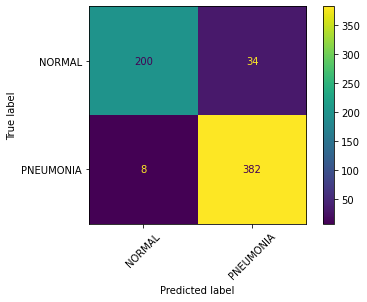

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ label['label']for label in labels])
disp.plot(xticks_rotation=45)

print(classification_report(y_true,y_pred,target_names=[ label['label']for label in labels],digits=4))